# Task 10

In [1]:
import requests
from bs4 import BeautifulSoup
import time
import re
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.rcParams["figure.figsize"] = (8, 5)

BASE_URL = "https://internshala.com/internships/data-analysis-internship{suffix}"

HEADERS = {
    "User-Agent": "Mozilla/5.0"
}

MAX_PAGES = 3
SLEEP_SEC = 2

In [3]:
def get_soup(page_num: int):
    if page_num == 1:
        url = "https://internshala.com/internships/data-analysis-internship/"
    else:
        url = f"https://internshala.com/internships/data-analysis-internship/internship/page-{page_num}"

    print("Fetching:", url)

    response = requests.get(url, headers=HEADERS)
    response.raise_for_status()

    soup = BeautifulSoup(response.text, "html.parser")
    return soup

soup_test = get_soup(1)
print("Page fetched successfully!")


Fetching: https://internshala.com/internships/data-analysis-internship/
Page fetched successfully!


In [4]:
def parse_job_cards(soup):
    jobs = []

    job_cards = soup.find_all("div", class_=["container-fluid", "individual_internship"])
    
    print("Job cards found:", len(job_cards))
    
    for card in job_cards:
        title_tag = card.find("a", class_="job-title-href")
        title = title_tag.get_text(strip=True) if title_tag else None

        company_tag = card.find("p", class_="company-name")
        company = company_tag.get_text(strip=True) if company_tag else None

        if (title is None) and (company is None):
            continue

        loc_container = card.find("div", class_="row-1-item locations")
        if loc_container:
            loc_a = loc_container.find("a")
            location = loc_a.get_text(strip=True) if loc_a else None
        else:
            location = None

        salary_tag = card.find("span", class_="stipend")
        salary = salary_tag.get_text(strip=True) if salary_tag else None

        skill_tags = card.find_all("div", class_="job_skill")
        skills = [tag.get_text(strip=True) for tag in skill_tags]
        
        jobs.append({
            "title": title,
            "company": company,
            "location": location,
            "salary": salary,
            "skills_raw": ", ".join(skills) if skills else None,
            "skills_list": skills
        })
    
    return jobs


In [5]:
def scrape_jobs(max_pages: int):
    all_jobs = []
    for page in range(1, max_pages + 1):
        soup = get_soup(page)
        page_jobs = parse_job_cards(soup)
        print(f"Page {page}: {len(page_jobs)} jobs")
        all_jobs.extend(page_jobs)
        time.sleep(SLEEP_SEC)
    return all_jobs

In [6]:
soup_test = get_soup(1)
test_jobs = parse_job_cards(soup_test)
test_jobs[:5]


Fetching: https://internshala.com/internships/data-analysis-internship/
Job cards found: 47


[{'title': 'Doom Scroller',
  'company': 'Dropz',
  'location': 'Kochi',
  'salary': '₹ 8,000 - 12,000 /month',
  'skills_raw': 'Content Writing, Research, Digital Marketing, Market Analysis, Video Making, Content Management, Marketing Strategy, Client Interaction, Business Analysis, Business Research, Client Relationship, Market research, Sales, Marketing Strategies, Client Interaction, Business Analysis, Business Research, Client Relationship, English Proficiency (Written), Market research, Data Analysis, MS-Excel, Business Research, Sales, Effective Communication, Data Analysis, MS-Office, MS-PowerPoint, MS-Excel, Client Relationship Management (CRM), Adaptability, Interpersonal skills, Effective Communication, MS-Office, Analytical Thinking, MS-Excel, English Proficiency (Spoken), Effective Communication, Data Analysis, MS-Office, Typing, MS-Excel, Data Analysis, Microsoft Outlook, Social Media Marketing, Content Writing, Google Analytics, Adobe Illustrator, Search Engine Marketing

In [7]:
raw_jobs = scrape_jobs(MAX_PAGES)
len(raw_jobs)


Fetching: https://internshala.com/internships/data-analysis-internship/
Job cards found: 47
Page 1: 44 jobs
Fetching: https://internshala.com/internships/data-analysis-internship/internship/page-2
Job cards found: 44
Page 2: 41 jobs
Fetching: https://internshala.com/internships/data-analysis-internship/internship/page-3
Job cards found: 44
Page 3: 41 jobs


126

In [8]:
df = pd.DataFrame(test_jobs) 
df.head()


,title,company,location,salary,skills_raw,skills_list
0,Doom Scroller,Dropz,Kochi,"₹ 8,000 - 12,000 /month","Content Writing, Research, Digital Marketing, ...","[Content Writing, Research, Digital Marketing,..."
1,Doom Scroller,Dropz,Kochi,"₹ 8,000 - 12,000 /month","Content Writing, Research, Digital Marketing, ...","[Content Writing, Research, Digital Marketing,..."
2,Business Consultant,She Can Foundation,Work from home,"₹ 1,500 - 15,000 lump sum","Client Interaction, Business Analysis, Busines...","[Client Interaction, Business Analysis, Busine..."
3,Social Consultant,Basti Ki Pathshala Foundation,Work from home,"₹ 1,500 - 15,000 lump sum","Client Interaction, Business Analysis, Busines...","[Client Interaction, Business Analysis, Busine..."
4,Business Consultant,The Indian Express,Noida,"₹ 7,000 - 10,000 /month","MS-Excel, Business Research, Sales, Effective ...","[MS-Excel, Business Research, Sales, Effective..."


In [9]:

df = pd.DataFrame(raw_jobs)

df["salary_clean"] = df["salary"].str.replace("\n", " ", regex=False).str.strip()

df["title"] = df["title"].fillna("Not specified")
df["company"] = df["company"].fillna("Not specified")
df["location"] = df["location"].fillna("Not specified")

def extract_skills(skills_raw):
    if not skills_raw:
        return []
    skills = [s.strip() for s in skills_raw.split(",") if s.strip()]
    return list(dict.fromkeys(skills))

df["skills_list"] = df["skills_raw"].apply(extract_skills)



In [10]:
df.head()

,title,company,location,salary,skills_raw,skills_list,salary_clean
0,Doom Scroller,Dropz,Kochi,"₹ 8,000 - 12,000 /month","Content Writing, Research, Digital Marketing, ...","[Content Writing, Research, Digital Marketing,...","₹ 8,000 - 12,000 /month"
1,Doom Scroller,Dropz,Kochi,"₹ 8,000 - 12,000 /month","Content Writing, Research, Digital Marketing, ...","[Content Writing, Research, Digital Marketing,...","₹ 8,000 - 12,000 /month"
2,Business Consultant,She Can Foundation,Work from home,"₹ 1,500 - 15,000 lump sum","Client Interaction, Business Analysis, Busines...","[Client Interaction, Business Analysis, Busine...","₹ 1,500 - 15,000 lump sum"
3,Social Consultant,Basti Ki Pathshala Foundation,Work from home,"₹ 1,500 - 15,000 lump sum","Client Interaction, Business Analysis, Busines...","[Client Interaction, Business Analysis, Busine...","₹ 1,500 - 15,000 lump sum"
4,Business Consultant,The Indian Express,Noida,"₹ 7,000 - 10,000 /month","MS-Excel, Business Research, Sales, Effective ...","[MS-Excel, Business Research, Sales, Effective...","₹ 7,000 - 10,000 /month"


In [11]:
top_locations = df["location"].value_counts().head(5)
top_locations


location
Work from home    63
Bangalore          7
Delhi              6
Mumbai             6
Pune, Balewadi     6
Name: count, dtype: int64

In [12]:
all_skills = []
for sk in df["skills_list"]:
    all_skills.extend(sk)

skill_counts = Counter(all_skills)
top_skills = skill_counts.most_common(10)
top_skills


[('Data Analysis', 75),
 ('MS-Excel', 42),
 ('Effective Communication', 32),
 ('English Proficiency (Spoken)', 28),
 ('Business Analysis', 27),
 ('Social Media Marketing', 25),
 ('Time Management', 23),
 ('Digital Marketing', 21),
 ('Market research', 21),
 ('English Proficiency (Written)', 21)]

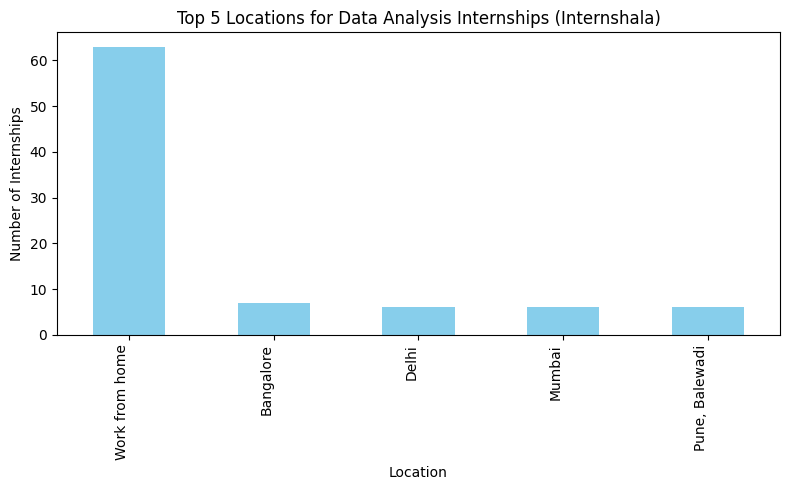

In [13]:
top_locations.plot(kind="bar", color="skyblue")
plt.title("Top 5 Locations for Data Analysis Internships (Internshala)")
plt.xlabel("Location")
plt.ylabel("Number of Internships")
plt.xticks(rotation=90, ha="right")
plt.tight_layout()
plt.show()


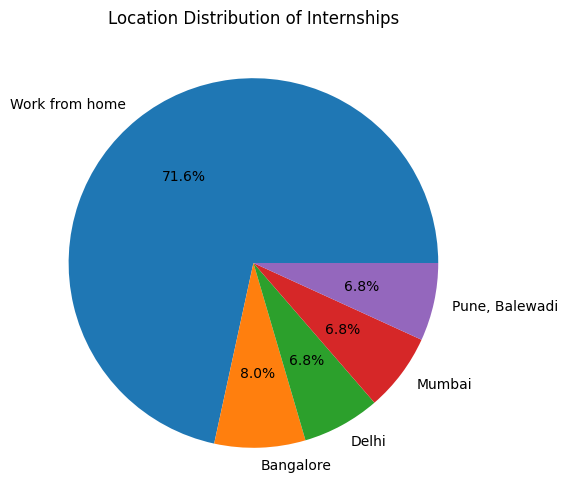

In [14]:
top_locations.plot(kind="pie", autopct="%1.1f%%", figsize=(6,6))
plt.title("Location Distribution of Internships")
plt.ylabel("")
plt.show()


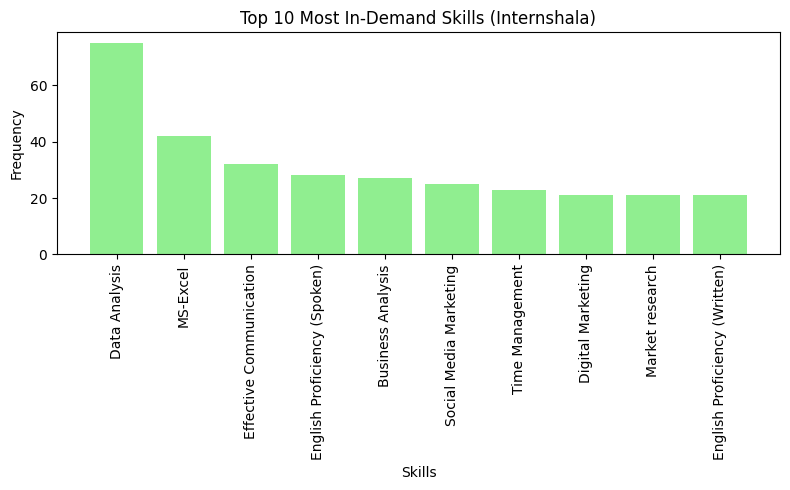

In [15]:
skills = [s for s, _ in top_skills]
counts = [c for _, c in top_skills]

plt.bar(skills, counts, color="lightgreen")
plt.title("Top 10 Most In-Demand Skills (Internshala)")
plt.xlabel("Skills")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [16]:
df.to_csv("internshala_data_analyst_jobs.csv", index=False)
print("Saved as internshala_data_analyst_jobs.csv")

Saved as internshala_data_analyst_jobs.csv
